# Lab 4: Sequential Data

This lab is based on an assignment developed by Prof. Lisa Zhang.

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.
5. Understand how transfer learning can be applied to NLP projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1KS2ogUmVDJuw0U0hz8dD1nLYzUY3cwtf/view?usp=sharing

# PART A - Spam Detection [30 pt]

In this part we will construct a LSTM model for identifying spam from non spam messages.

In [ ]:
#Need to use older version of several pakages in order to run the code successfuly
!pip install torchtext==0.6.0
!pip install fastai==1.0.51
!pip install fastprogress==0.1.22

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchtext

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Part 1. Data Cleaning [10 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [3]:
file_dir = '/content/gdrive/MyDrive/MIE1517/a4/SMSSpamCollection'

In [4]:
ph,ps = False,False
for line in open(file_dir):
  message = line.split(maxsplit=1)
  if message[0] == 'ham' and ph == False:
    print(f"[non-spam message: \n{message[1]}, label is {message[0]}]")
    print("-----------------------------------------------------------------")
    ph = True
  elif message[0] == 'spam' and ps == False:
    print(f"[spam message: \n{message[1]}, label is {message[0]}]")
    ps = True
  if ph == True and ps == True:  
    break

[non-spam message: 
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
, label is ham]
-----------------------------------------------------------------
[spam message: 
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
, label is spam]


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [5]:
num_spam = 0
num_ham = 0
for line in open(file_dir):
  message = line.split(maxsplit=1)
  if message[0] == 'spam':
    num_spam += 1
  if message[0] == 'ham':
    num_ham += 1  

print(f"There are {num_spam} spam messages and {num_ham} non-spam messages.")


There are 747 spam messages and 4827 non-spam messages.


### Part (c) [2 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantage:
1. The size of volcabulary is much smaller so the memory requirement is also smaller.
2. Misspelled words can be recognized.

Disadvantage:
1. It requires larger hidden layer and more computation.
2. The accuracy may be lower than word level RNN.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [6]:
print(torchtext.__version__)

0.6.0


In [7]:
!python --version

Python 3.7.15


In [8]:
#import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset(file_dir, # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)


train, valid, test = dataset.split([0.6, 0.2, 0.2],stratified=True,random_state=np.random.seed(42))
print(f"There are {len(train)} training data, {len(valid)} validation data and {len(test)} test data,")
# dataset[0].sms
# dataset[0].label
# train, valid, test = ...

There are 3343 training data, 1115 validation data and 1114 test data,


In [ ]:
#dataset[0].sms,dataset[0].label

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

If we do not duplicate the spam messages, the model will bias towards the non-spam class when predicting. As an extreme example, the model may predict all the samples as non-spam and it will still get a good accuracy of nearly 87%. But in fact, the goal is to identify spam messages, so the model actually performed poorly. We can see this if we use metrics like recall and f1 score.<br>
If we duplicate the minority class, the model will not bias towards a particular class and its predictions will be more reliable.

In [9]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [10]:
text_field.build_vocab(train)

In [11]:
print(text_field.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7ff702fc5f50>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, 'd': 14, '0': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'v': 30, 'E': 31, '5': 32, 'C': 33, 'S': 34, 'O': 35, 'I': 36, '7': 37, '4': 38, 'x': 39, 'N': 40, 'A': 41, '3': 42, '6': 43, 'R': 44, '!': 45, ',': 46, '9': 47, 'P': 48, 'W': 49, 'M': 50, 'U': 51, 'L': 52, 'H': 53, 'B': 54, '/': 55, 'D': 56, 'F': 57, 'G': 58, 'Y': 59, '?': 60, "'": 61, '£': 62, '-': 63, ':': 64, '&': 65, 'X': 66, 'z': 67, 'V': 68, 'j': 69, 'K': 70, '*': 71, 'J': 72, ')': 73, '+': 74, ';': 75, '(': 76, 'q': 77, 'Q': 78, '"': 79, '#': 80, '=': 81, '@': 82, '>': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '$': 87, '[': 88, ']': 89, '\x92': 90, '<': 91, '‘': 92, '|': 93, '\x93': 94, '¡': 95, '_': 96, '…': 97, '%': 98,

text_field.vocab.stoi returns a dictionary that maps each char/token strings to an integer value/numerical identifiers

In [12]:
print(text_field.vocab.itos)

['<unk>', '<pad>', ' ', 'e', 'o', 't', 'a', 'n', 'r', 'i', 's', 'l', 'u', 'h', 'd', '0', '.', 'c', 'm', 'y', 'w', 'p', 'g', '1', 'f', '2', 'b', 'T', '8', 'k', 'v', 'E', '5', 'C', 'S', 'O', 'I', '7', '4', 'x', 'N', 'A', '3', '6', 'R', '!', ',', '9', 'P', 'W', 'M', 'U', 'L', 'H', 'B', '/', 'D', 'F', 'G', 'Y', '?', "'", '£', '-', ':', '&', 'X', 'z', 'V', 'j', 'K', '*', 'J', ')', '+', ';', '(', 'q', 'Q', '"', '#', '=', '@', '>', 'Z', 'ü', 'Ü', '$', '[', ']', '\x92', '<', '‘', '|', '\x93', '¡', '_', '…', '%', '–', 'ú', '\\', 'é', '\x94', '’', '~', '\x96', 'É', 'ì']


text_field.vocab.itos returns an array of characters which are indexed by their integer values.(The values are the indexes of text_field.vocab.stoi)

### Part (g) [1 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

'unk' represents unknown tokens that are not identified in the existing vocabulary.<br>
'pad' represents padding tokens that are used to make every data entry/sequence the same length.

### Part (h) [1 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [13]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [14]:
for batch in train_iter:
    
    #print(len(batch))
    print(batch.sms[0])
    print(batch.sms[1])
    print(batch.sms[0].shape)
    print(batch.sms[1].shape)    
    #print(batch.label)
    break

tensor([[35, 29,  2,  ..., 16, 16, 16],
        [36,  2, 20,  ..., 14, 16,  1],
        [49, 13,  6,  ..., 14, 16,  1],
        ...,
        [59,  3, 10,  ...,  1,  1,  1],
        [17, 12, 14,  ...,  1,  1,  1],
        [36,  2, 24,  ...,  1,  1,  1]])
tensor([111, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 109, 109, 109,
        109, 109, 109, 109, 109, 109, 109, 109, 109, 108, 108, 108, 107, 107,
        107, 107, 107, 107])
torch.Size([32, 111])
torch.Size([32])


batch.sms[1] contains the lengths of all the original data entries in the batch(ie.before adding the paddings)

In [16]:
for index, batch in enumerate(train_iter):
  if index == 10:
    break
  print(f"batch number {index+1}")
  print(f"The maximum length of the input sequence is {int(batch.sms[1][0])}")
  total = 0
  for lens in range(len(batch.sms[1])):
    # batch.sms[1] is sorted in descending order, 
    # so we can use the first value to subtract each value in the list and sum them up
    total = total + batch.sms[1][0] - batch.sms[1][lens]
  print(f"{total} paddings are used in the batch")

batch number 1
The maximum length of the input sequence is 45
19 paddings are used in the batch
batch number 2
The maximum length of the input sequence is 51
10 paddings are used in the batch
batch number 3
The maximum length of the input sequence is 65
44 paddings are used in the batch
batch number 4
The maximum length of the input sequence is 50
16 paddings are used in the batch
batch number 5
The maximum length of the input sequence is 49
60 paddings are used in the batch
batch number 6
The maximum length of the input sequence is 180
219 paddings are used in the batch
batch number 7
The maximum length of the input sequence is 158
11 paddings are used in the batch
batch number 8
The maximum length of the input sequence is 150
25 paddings are used in the batch
batch number 9
The maximum length of the input sequence is 78
72 paddings are used in the batch
batch number 10
The maximum length of the input sequence is 20
111 paddings are used in the batch


## Part 2. Model Building [5 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [17]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors
print(ident[x].shape)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])
torch.Size([2, 2, 10])


In [18]:
class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN1, self).__init__()
        self.name = 'rnn1'
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        #print("x:",x.shape)
        x = self.emb[x]
        #print("x:",x.shape)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        #print("h0:",h0.shape)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        #print("out",out.shape)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        #print("out",out.shape)
        return out

In [19]:
tmp = RNN1(10,10,2)
tmp

RNN1(
  (rnn): RNN(10, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
#x: torch.Size([32, 38])
#x: torch.Size([32, 38, 113])
#h0: torch.Size([1, 32, 100])
#out torch.Size([32, 38, 100])
#out torch.Size([32, 2])

## Part 3. Training [8 pt]

### Part (a) [2 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [20]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for message, labels in data:
        output = model(message[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total


### Part (b) [2 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [21]:
import matplotlib.pyplot as plt

In [22]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,batch_size,learning_rate,epoch)
    return path


In [23]:
def train_rnn_network(model, train, valid, batch_size = 32,num_epochs=5, learning_rate=1e-5):

# need to add the bucket iterators for train and val
    train_iter = torchtext.data.BucketIterator(train,batch_size=32,
                sort_key=lambda x: len(x.sms), # to minimize padding
                sort_within_batch=True,        # sort within each batch
                repeat=False)             # repeat the iterator for many epochs

    val_iter = torchtext.data.BucketIterator(valid,batch_size=32,
                sort_key=lambda x: len(x.sms), # to minimize padding
                sort_within_batch=True,        # sort within each batch
                repeat=False)             # repeat the iterator for many epochs


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for messages, labels in train_iter:
            optimizer.zero_grad()
            pred = model(messages[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            #break
        losses.append(float(loss))
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_iter))
        valid_acc.append(get_accuracy(model, val_iter))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.713670; Train Acc 0.577682; Val Acc 0.740807
Epoch 2; Loss 0.678891; Train Acc 0.652960; Val Acc 0.708520
Epoch 3; Loss 0.611678; Train Acc 0.705853; Val Acc 0.713901
Epoch 4; Loss 0.418699; Train Acc 0.885757; Val Acc 0.909417
Epoch 5; Loss 0.283213; Train Acc 0.916100; Val Acc 0.886099
Epoch 6; Loss 0.763755; Train Acc 0.929862; Val Acc 0.879821
Epoch 7; Loss 0.151027; Train Acc 0.909634; Val Acc 0.946188
Epoch 8; Loss 0.121925; Train Acc 0.933842; Val Acc 0.890583
Epoch 9; Loss 0.199594; Train Acc 0.940806; Val Acc 0.946188
Epoch 10; Loss 0.084074; Train Acc 0.942796; Val Acc 0.951570


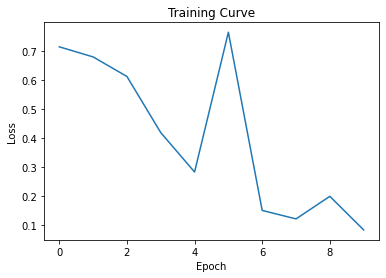

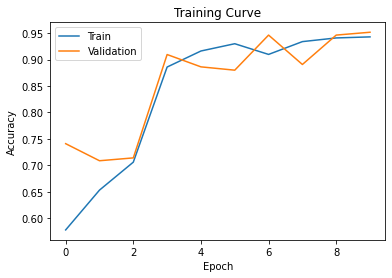

In [24]:
model = RNN1(len(text_field.vocab.itos),80,2)
train_rnn_network(model,train,valid,batch_size = 32,num_epochs=10, learning_rate=5e-5)

### Part (c) [2 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

1.Tuning learning rate

Epoch 1; Loss 0.700834; Train Acc 0.615984; Val Acc 0.853812
Epoch 2; Loss 0.701687; Train Acc 0.676007; Val Acc 0.573991
Epoch 3; Loss 0.221778; Train Acc 0.881280; Val Acc 0.936323
Epoch 4; Loss 0.309122; Train Acc 0.914608; Val Acc 0.933632
Epoch 5; Loss 0.048771; Train Acc 0.917427; Val Acc 0.946188
Epoch 6; Loss 0.674438; Train Acc 0.911955; Val Acc 0.949776
Epoch 7; Loss 0.212311; Train Acc 0.934008; Val Acc 0.937220
Epoch 8; Loss 0.218939; Train Acc 0.933013; Val Acc 0.947085
Epoch 9; Loss 0.075438; Train Acc 0.934173; Val Acc 0.944395
Epoch 10; Loss 0.112177; Train Acc 0.942961; Val Acc 0.932735


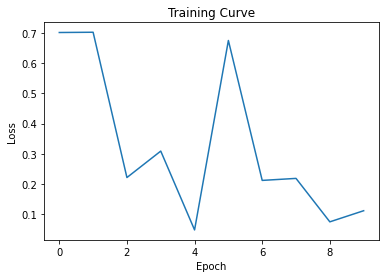

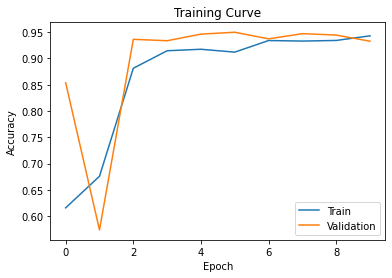

In [25]:
# increase learning rate
model = RNN1(len(text_field.vocab.itos),80,2)
train_rnn_network(model,train,valid,batch_size = 32,num_epochs=10, learning_rate=1e-4)

Epoch 1; Loss 0.672019; Train Acc 0.528436; Val Acc 0.167713
Epoch 2; Loss 0.721987; Train Acc 0.554303; Val Acc 0.260090
Epoch 3; Loss 0.610976; Train Acc 0.573868; Val Acc 0.381166
Epoch 4; Loss 0.695183; Train Acc 0.629581; Val Acc 0.591928
Epoch 5; Loss 0.697938; Train Acc 0.649644; Val Acc 0.617937
Epoch 6; Loss 0.689782; Train Acc 0.684629; Val Acc 0.702242
Epoch 7; Loss 0.608468; Train Acc 0.785442; Val Acc 0.821525
Epoch 8; Loss 0.503698; Train Acc 0.886586; Val Acc 0.870852
Epoch 9; Loss 0.320161; Train Acc 0.885591; Val Acc 0.920179
Epoch 10; Loss 0.276350; Train Acc 0.895871; Val Acc 0.924664


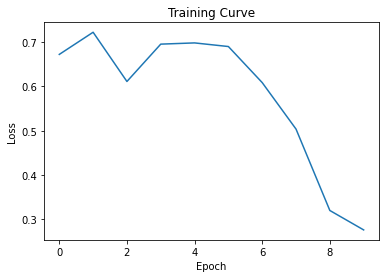

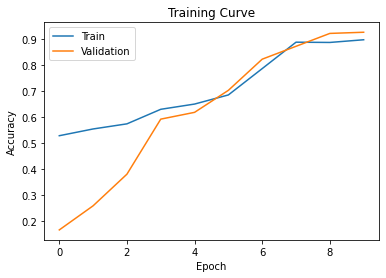

In [26]:
# decrease learning rate
model = RNN1(len(text_field.vocab.itos),80,2)
train_rnn_network(model,train,valid,batch_size = 32,num_epochs=10, learning_rate=2e-5)

2.Tuning hidden units

Epoch 1; Loss 0.671693; Train Acc 0.714144; Val Acc 0.755157
Epoch 2; Loss 0.481688; Train Acc 0.841154; Val Acc 0.795516
Epoch 3; Loss 0.158438; Train Acc 0.924225; Val Acc 0.927354
Epoch 4; Loss 0.335515; Train Acc 0.916929; Val Acc 0.934529
Epoch 5; Loss 0.115830; Train Acc 0.922733; Val Acc 0.906726
Epoch 6; Loss 0.701066; Train Acc 0.903001; Val Acc 0.872646
Epoch 7; Loss 0.093981; Train Acc 0.935334; Val Acc 0.944395
Epoch 8; Loss 0.117393; Train Acc 0.944951; Val Acc 0.928251
Epoch 9; Loss 0.217279; Train Acc 0.914774; Val Acc 0.939910
Epoch 10; Loss 0.052848; Train Acc 0.948599; Val Acc 0.952466


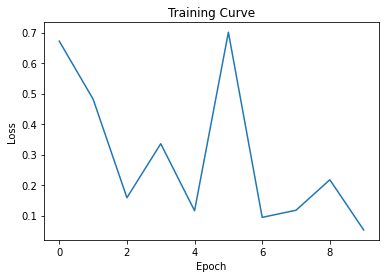

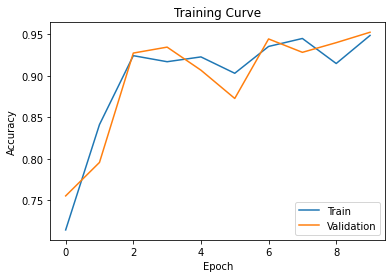

In [27]:
# increase hidden units
model = RNN1(len(text_field.vocab.itos),150,2)
train_rnn_network(model,train,valid,batch_size = 32,num_epochs=10, learning_rate=5e-5)

Epoch 1; Loss 0.742200; Train Acc 0.505223; Val Acc 0.864574
Epoch 2; Loss 0.673909; Train Acc 0.600895; Val Acc 0.810762
Epoch 3; Loss 0.644639; Train Acc 0.687614; Val Acc 0.734529
Epoch 4; Loss 0.694639; Train Acc 0.712651; Val Acc 0.755157
Epoch 5; Loss 0.659936; Train Acc 0.730725; Val Acc 0.718386
Epoch 6; Loss 0.631227; Train Acc 0.885094; Val Acc 0.882511
Epoch 7; Loss 0.176561; Train Acc 0.895208; Val Acc 0.904933
Epoch 8; Loss 0.539188; Train Acc 0.911955; Val Acc 0.890583
Epoch 9; Loss 0.237555; Train Acc 0.909634; Val Acc 0.903139
Epoch 10; Loss 0.138827; Train Acc 0.911789; Val Acc 0.908520


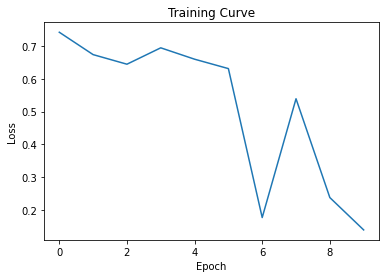

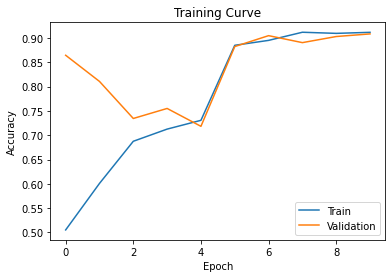

In [28]:
# decrease hidden units
model = RNN1(len(text_field.vocab.itos),50,2)
train_rnn_network(model,train,valid,batch_size = 32,num_epochs=10, learning_rate=5e-5)

3.Tuning the number of epoch

Epoch 1; Loss 0.648747; Train Acc 0.600398; Val Acc 0.393722
Epoch 2; Loss 0.706736; Train Acc 0.653126; Val Acc 0.566816
Epoch 3; Loss 0.558766; Train Acc 0.696568; Val Acc 0.652915
Epoch 4; Loss 0.479998; Train Acc 0.895871; Val Acc 0.913004
Epoch 5; Loss 0.186211; Train Acc 0.910960; Val Acc 0.910314
Epoch 6; Loss 0.539714; Train Acc 0.907644; Val Acc 0.849327
Epoch 7; Loss 0.100968; Train Acc 0.907312; Val Acc 0.932735
Epoch 8; Loss 0.576954; Train Acc 0.914110; Val Acc 0.934529
Epoch 9; Loss 0.160491; Train Acc 0.934671; Val Acc 0.932735
Epoch 10; Loss 0.207050; Train Acc 0.941137; Val Acc 0.918386
Epoch 11; Loss 0.166472; Train Acc 0.940806; Val Acc 0.939013
Epoch 12; Loss 0.155713; Train Acc 0.937821; Val Acc 0.947982
Epoch 13; Loss 0.541869; Train Acc 0.949428; Val Acc 0.940807
Epoch 14; Loss 0.216726; Train Acc 0.950423; Val Acc 0.934529
Epoch 15; Loss 0.302679; Train Acc 0.935666; Val Acc 0.904036
Epoch 16; Loss 0.168760; Train Acc 0.954402; Val Acc 0.945291
Epoch 17; Loss 0.

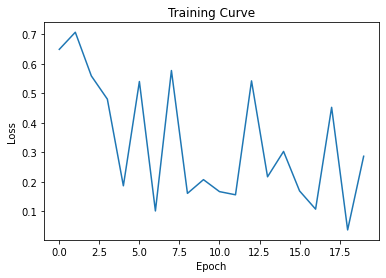

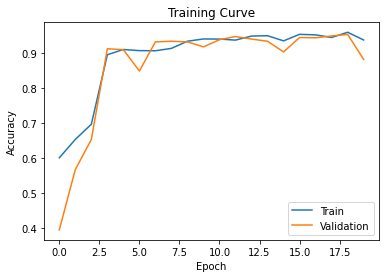

In [29]:
# use 20 epochs
model = RNN1(len(text_field.vocab.itos),80,2)
train_rnn_network(model,train,valid,batch_size = 32,num_epochs=20, learning_rate=5e-5)

Epoch 1; Loss 0.717811; Train Acc 0.659924; Val Acc 0.826009
Epoch 2; Loss 0.666726; Train Acc 0.737357; Val Acc 0.763229
Epoch 3; Loss 0.278489; Train Acc 0.884265; Val Acc 0.903139
Epoch 4; Loss 0.370185; Train Acc 0.905157; Val Acc 0.918386
Epoch 5; Loss 0.212768; Train Acc 0.912950; Val Acc 0.904036


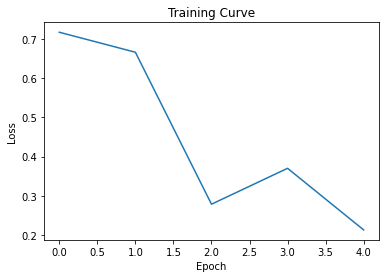

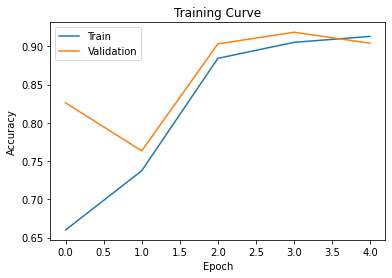

In [30]:
#use 5 epochs
model = RNN1(len(text_field.vocab.itos),80,2)
train_rnn_network(model,train,valid,batch_size = 32,num_epochs=5, learning_rate=5e-5)

4.Tuning the way to pool RNN output(The 2 ways mentioned above)

RNN2 uses self.fc(torch.max(out, dim=1)[0])

In [32]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN2, self).__init__()
        self.name = 'rnn2'
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        #print("x:",x.shape)
        x = self.emb[x]
        #print("x:",x.shape)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        #print("h0:",h0.shape)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        #print("out",out.shape)
        out = self.fc(torch.max(out, dim=1)[0])
        #print("out",out.shape)
        return out

Epoch 1; Loss 0.751693; Train Acc 0.480020; Val Acc 0.865471
Epoch 2; Loss 0.666299; Train Acc 0.902504; Val Acc 0.941704
Epoch 3; Loss 0.625220; Train Acc 0.878295; Val Acc 0.821525
Epoch 4; Loss 0.598580; Train Acc 0.941801; Val Acc 0.926457
Epoch 5; Loss 0.522737; Train Acc 0.889902; Val Acc 0.941704
Epoch 6; Loss 0.538020; Train Acc 0.925220; Val Acc 0.876233
Epoch 7; Loss 0.422013; Train Acc 0.921074; Val Acc 0.932735
Epoch 8; Loss 0.423006; Train Acc 0.926215; Val Acc 0.945291
Epoch 9; Loss 0.348907; Train Acc 0.918919; Val Acc 0.939910
Epoch 10; Loss 0.245996; Train Acc 0.832034; Val Acc 0.956951


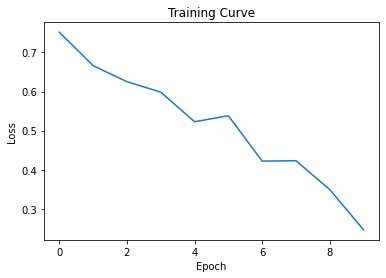

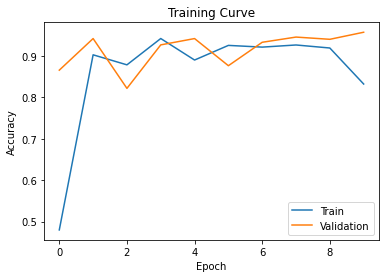

In [33]:
model = RNN2(len(text_field.vocab.itos),80,2)
train_rnn_network(model,train,valid,batch_size = 32,num_epochs=10, learning_rate=5e-5)

RNN3 uses max-pooling and average-pooling of the RNN outputs

In [34]:
class RNN3(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN3, self).__init__()
        self.name = 'rnn3'
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        #print("x:",x.shape)
        x = self.emb[x]
        #print("x:",x.shape)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        #print("h0:",h0.shape)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        #print("out",out.shape)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

Epoch 1; Loss 0.678875; Train Acc 0.815288; Val Acc 0.707623
Epoch 2; Loss 0.705769; Train Acc 0.537888; Val Acc 0.165919
Epoch 3; Loss 0.608247; Train Acc 0.558614; Val Acc 0.191928
Epoch 4; Loss 0.629336; Train Acc 0.832366; Val Acc 0.690583
Epoch 5; Loss 0.643760; Train Acc 0.897198; Val Acc 0.822422
Epoch 6; Loss 0.570004; Train Acc 0.922235; Val Acc 0.894170
Epoch 7; Loss 0.374780; Train Acc 0.914939; Val Acc 0.912108
Epoch 8; Loss 0.198168; Train Acc 0.936826; Val Acc 0.915695
Epoch 9; Loss 0.301881; Train Acc 0.947107; Val Acc 0.928251
Epoch 10; Loss 0.164354; Train Acc 0.949262; Val Acc 0.938117


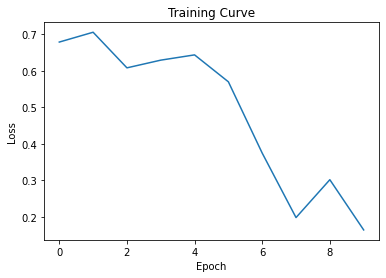

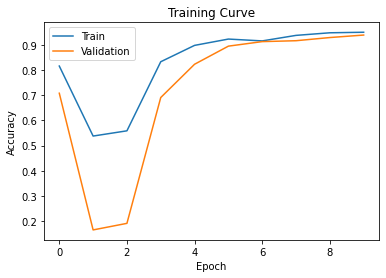

In [35]:
model = RNN3(len(text_field.vocab.itos),80,2)
train_rnn_network(model,train,valid,batch_size = 32,num_epochs=10, learning_rate=5e-5)

The best model uses RNN2 model which uses self.fc(torch.max(out, dim=1)[0])

### Part (d) [1 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [36]:
# load best model
best_model = RNN2(len(text_field.vocab.itos),80,2)
model_path = get_model_name('rnn2', batch_size=32, learning_rate=5e-5, epoch=9)
state = torch.load(model_path)
best_model.load_state_dict(state)

<All keys matched successfully>

In [37]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields) # TODO

In [38]:
spam_iter = torchtext.data.BucketIterator(valid_spam,batch_size=32,
            sort_key=lambda x: len(x.sms), # to minimize padding
            sort_within_batch=True,        # sort within each batch
            repeat=False)             # repeat the iterator for many epochs

nospam_iter = torchtext.data.BucketIterator(valid_nospam,batch_size=32,
            sort_key=lambda x: len(x.sms), # to minimize padding
            sort_within_batch=True,        # sort within each batch
            repeat=False)             # repeat the iterator for many epochs

In [39]:
fpr = 1 - get_accuracy(best_model, nospam_iter)
fnr = 1 - get_accuracy(best_model, spam_iter)

FPR = FP/FP+TN<br>
FNR = FN/FN+TP

In [40]:
print(f"False positive rate is {fpr}")
print(f"False negative rate is {fnr}")

False positive rate is 0.007253886010362698
False negative rate is 0.2733333333333333


### Part (e) [1 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

FP means that the algorithm identifies the non-spam message as spam. This is acceptable in most cases. It just takes some time for the users to manually check their trash box in order to validate the mails. But in some cases, the users might miss important mails if they forget to check the trash box.<br>
FN means that the algorithm identifies the spam message as non-spam. In other words, the spam message bypass the algorithm and enter the mail box. This is the most problematic situation which may lead to serious consequences. In spam detection, we want to keep the FNR as low as possible.

## Part 4. Evaluation [7 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [41]:
best_model = RNN2(len(text_field.vocab.itos),80,2)
model_path = get_model_name('rnn2', batch_size=32, learning_rate=5e-5, epoch=9)
state = torch.load(model_path)
best_model.load_state_dict(state)

<All keys matched successfully>

In [42]:
test_iter = torchtext.data.BucketIterator(test,batch_size=32,
            sort_key=lambda x: len(x.sms), # to minimize padding
            sort_within_batch=True,        # sort within each batch
            repeat=False)             # repeat the iterator for many epochs

In [43]:
print(f"The accuracy is {get_accuracy(best_model,test_iter)}")

The accuracy is 0.9622980251346499


### Part (b) [1 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [44]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields) # TODO

In [45]:
spam_iter2 = torchtext.data.BucketIterator(test_spam,batch_size=32,
            sort_key=lambda x: len(x.sms), # to minimize padding
            sort_within_batch=True,        # sort within each batch
            repeat=False)             # repeat the iterator for many epochs

nospam_iter2 = torchtext.data.BucketIterator(test_nospam,batch_size=32,
            sort_key=lambda x: len(x.sms), # to minimize padding
            sort_within_batch=True,        # sort within each batch
            repeat=False)             # repeat the iterator for many epochs

In [46]:
fpr2 = 1 - get_accuracy(best_model, nospam_iter2)
fnr2 = 1 - get_accuracy(best_model, spam_iter2)

In [47]:
print(f"False positive rate is {fpr2}")
print(f"False negative rate is {fnr2}")

False positive rate is 0.0031088082901554737
False negative rate is 0.261744966442953


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [48]:
dic = {0:'non-spam',1:'spam'}

In [49]:
msg = "machine learning is sooo cool!"
num_rep = torch.tensor([text_field.vocab.stoi[char] for char in msg])
#np.array(num_rep).shape
activation = nn.Softmax(dim=1)
out = activation(best_model(num_rep.unsqueeze(0)))
print("probabilities:",out)
pred = out.max(1, keepdim=True)[1]
print("predictions:", pred)

probabilities: tensor([[0.7738, 0.2262]], grad_fn=<SoftmaxBackward0>)
predictions: tensor([[0]])


In [50]:
print(f"The prediction is {dic[int(pred[0][0])]}")

The prediction is non-spam


### Part (d) [2 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

It is a difficult task. Generally, it is easy to acheive a high accuracy for spam detection but very hard to achieve a high recall or a low False Negative Rate. These are the most important metrics in spam detection. A high FPR can negatively impact user experience but it is a less serious problem compared to high FNR or low recall. A baseline model can be built by feeding common spam key words like "win money", "get $50 off" to the algorithm so that when the incoming message contains at least 2(or maybe 1) of these key words, it will classify the message as spam.

# PART B - Transfer Learning [20 pt]

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

Provided below is some helper code to get you started.

#### Helper Code

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# install relevant libraries
#!pip install fastai

In [52]:
# load relevant libraries
import fastai
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [53]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2022-11-09 03:04:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip.3’

smsspamcollection.z 100%[===================>] 198.65K   323KB/s    in 0.6s    

2022-11-09 03:04:23 (323 KB/s) - ‘smsspamcollection.zip.3’ saved [203415/203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SMSSpamCollection       
replace readme? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: readme                  


This time we will load the data using pandas.

In [54]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [55]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [56]:
# split the data and check dimensions

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)

In [57]:
df_trn.shape, df_val.shape

((3900, 2), (1672, 2))

### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [29]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

### Testing the language model


In [30]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when John Law of Sale of close to
The problem usually starts when about 7 people at each side have already gone missed
The problem usually starts when one or more of the Earth 's people is
The problem usually starts when the quality of the DVD is small .
The problem usually starts when an open door or open front is past at a


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [31]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,6.107907,4.053057,0.271429,00:02
1,5.267975,4.014572,0.285714,00:02
2,4.791135,4.132245,0.285714,00:02
3,4.477106,4.084064,0.342857,00:02


epoch,train_loss,valid_loss,accuracy,time
0,4.015735,4.035884,0.328571,00:02
1,3.968851,4.041389,0.300000,00:02
2,3.913146,4.037457,0.300000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.847589,4.027214,0.314286,00:02
1,3.835068,4.023201,0.300000,00:02
2,3.822135,4.023871,0.300000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.795927,4.025019,0.300000,00:03
1,3.783074,4.021153,0.285714,00:03
2,3.759214,4.018986,0.271429,00:03


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [32]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [33]:
data_clas.show_batch()

text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , delete the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
"xxbos no , i * did n't * mean to post it . i wrote it , and like so many other times i 've xxunk stuff to you , i let it sit there . it xxup was what i was feeling at the time . i was angry . xxmaj before i left , i hit send , then stop . xxmaj it was n't there . i",ham
"xxbos xxmaj good evening xxmaj sir , hope you are having a nice day . i wanted to bring it to your notice that i have been late in paying rent for the past few months and have had to pay a $ < # > charge . i felt it would be inconsiderate of me to nag about something you give at great cost to yourself and that 's",ham
"xxbos xxmaj you are everywhere xxunk , on the floor , the windows , even on my shirt . xxmaj and sometimes when i open my xxunk , you are all that comes xxunk out . i dream of my world without you , then half my xxunk are out too . a time of joy for me , lots of tv shows i.ll see . xxmaj but i guess",ham
"xxbos xxmaj spoke with uncle john today . xxmaj he xxunk feels that you need to sacrifice to keep me here . xxmaj he 's going to call you . xxmaj when he does , i beg you to just listen . xxmaj do nt make any promises or make it clear things are not easy . xxmaj and i need you to please let us work things out .",ham


In [34]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [35]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03


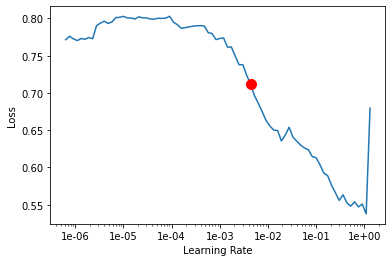

In [36]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [37]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.360663,0.073005,0.980263,00:04
1,0.210112,0.058029,0.987440,00:04
2,0.145175,0.059684,0.986842,00:03
3,0.119703,0.052550,0.987440,00:04
4,0.101440,0.060145,0.988038,00:04


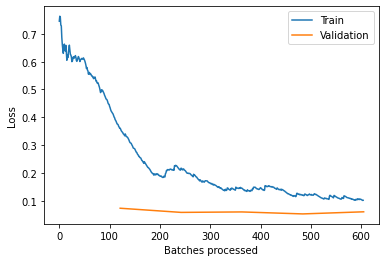

In [38]:
learn_classifier.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


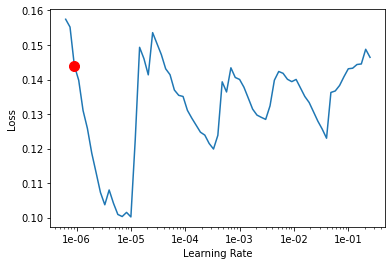

In [39]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [40]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category ham, tensor(0), tensor([9.9999e-01, 6.2528e-06]))

In [41]:
# predict
learn_classifier.predict('Free entry call back now')

(Category spam, tensor(1), tensor([0.1873, 0.8127]))

Next we will evaluate on all of our validation data.

In [42]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1672, 2])

In [43]:
valid_preds[:5]

tensor([[1.0000e+00, 6.2542e-08],
        [2.0041e-01, 7.9959e-01],
        [9.9994e-01, 6.0508e-05],
        [1.0000e+00, 1.8077e-06],
        [1.0000e+00, 4.9166e-06]])

In [68]:
valid_label.shape

torch.Size([1672])

## Part 1. Evaluate Performance [10pt]

### Part (a) [5pt]

Implement the above helper code for spam detection. 

What is the accuracy obtained with ULMFiT? How does ULMFiT compare to the approach in the first part using only LSTM?

In [58]:
from sklearn.metrics import confusion_matrix, recall_score,precision_score,accuracy_score
import seaborn as sns

In [73]:
def trans_detection():
  data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
  lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)
  lang_mod.fit_one_cycle(4, max_lr= 5e-02)
  lang_mod.freeze_to(-1)
  lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
  lang_mod.freeze_to(-2)
  lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
  lang_mod.unfreeze()
  lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

  # save language model
  lang_mod.save_encoder('my_awsome_encoder')

  data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)
  learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)
  learn_classifier.load_encoder('my_awsome_encoder')
  learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))
  learn_classifier.recorder.plot_losses()
  valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
  #valid_preds.shape
  #correct, total = 0, 0
  pred = valid_preds.max(1, keepdim=True)[1]
  #correct += pred.eq(valid_label.view_as(pred)).sum().item()
  #total += valid_label.shape[0]
  #acc = correct / total
  acc1 = accuracy_score(y_true=valid_label,y_pred=pred.reshape(-1))
  return learn_classifier, pred, valid_label, acc1

epoch,train_loss,valid_loss,accuracy,time
0,6.092806,4.562314,0.214658,00:03
1,5.257709,4.129259,0.247396,00:03
2,4.781076,3.992717,0.264881,00:03
3,4.467471,3.969203,0.266543,00:03


epoch,train_loss,valid_loss,accuracy,time
0,4.011818,3.927115,0.273537,00:03
1,3.960836,3.891668,0.278547,00:03
2,3.919729,3.885797,0.277282,00:03


epoch,train_loss,valid_loss,accuracy,time
0,3.837974,3.874057,0.280308,00:03
1,3.837394,3.863646,0.281548,00:03
2,3.817136,3.865811,0.281027,00:03


epoch,train_loss,valid_loss,accuracy,time
0,3.814533,3.852127,0.283854,00:04
1,3.784154,3.833634,0.286483,00:04
2,3.760856,3.832361,0.286334,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.372220,0.109452,0.984450,00:04
1,0.188459,0.057657,0.986842,00:04
2,0.142814,0.052631,0.988636,00:04
3,0.122363,0.053721,0.988636,00:04
4,0.100719,0.055787,0.988636,00:04


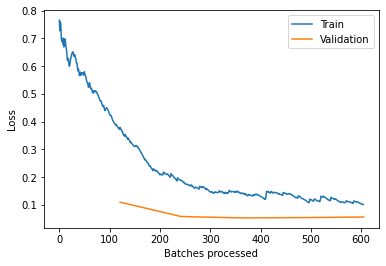

In [74]:
trans_model,pred_trans, label_trans, acc = trans_detection()

In [75]:
print(f"The accuracy for ULMFiT is {acc}")

The accuracy for ULMFiT is 0.9886363636363636


The accuracy of the transfer learning model is higher than the regular LSTM model. <br>fit_one_cycle() uses large, cyclical learning rates to train models significantly quicker and with higher accuracy.

### Part (b) [5pt]
Provide a confusion matrix of the performance for the two models. How do they compare? Are there any qualitative differences between the performances (i.e. examine the samples for which the models differred)?

The ULMFiT model has higher recall and accuracy but lower precision than normal LSTM model. When doing spam detection, recall is one of the most important metrics. ULMFiT model is the best model so far. 

In [62]:
def get_pl(model, data):

    for message, labels in data:
        output = model(message[0])
        output = output.max(1, keepdim=True)[1]
    return output, labels


In [63]:
best_model = RNN2(len(text_field.vocab.itos),80,2)
model_path = get_model_name('rnn2', batch_size=32, learning_rate=5e-5, epoch=9)
state = torch.load(model_path)
best_model.load_state_dict(state)

test_iter = torchtext.data.BucketIterator(test,batch_size=1114,
            sort_key=lambda x: len(x.sms), # to minimize padding
            sort_within_batch=True,        # sort within each batch
            repeat=False)             # repeat the iterator for many epochs
pred_rnn, label_rnn =  get_pl(best_model,test_iter)          

confusion metrics for ULMFiT

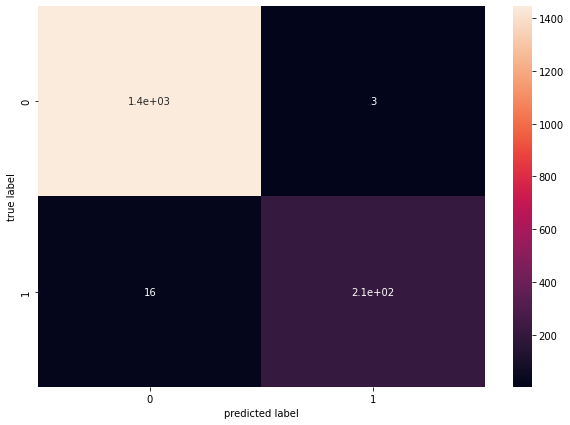

In [76]:
cm = confusion_matrix(y_true=label_trans,y_pred=pred_trans.flatten())
df_cm = pd.DataFrame(data=cm,columns=[0,1],index=[0,1])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,xticklabels=[0,1],yticklabels=[0,1],annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [77]:
cm

array([[1445,    3],
       [  16,  208]])

In [78]:
print(f"The recall score is {recall_score(y_true=label_trans,y_pred=pred_trans.flatten())}")
print(f"The precision score is {precision_score(y_true=label_trans,y_pred=pred_trans.flatten())}")
print(f"The accuracy score is {accuracy_score(y_true=label_trans,y_pred=pred_trans.flatten())}")

The recall score is 0.9285714285714286
The precision score is 0.985781990521327
The accuracy score is 0.9886363636363636


connfusion metrics for normal LSTM

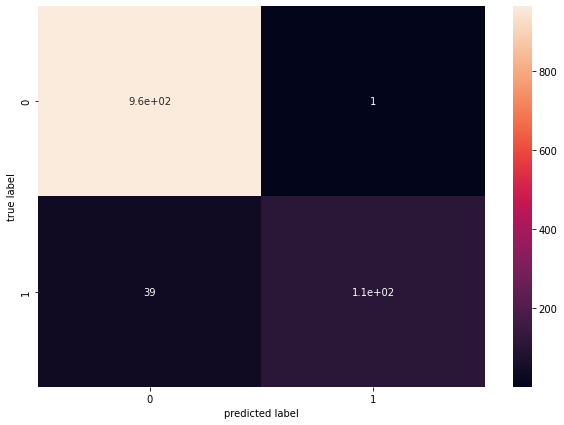

In [70]:
cm = confusion_matrix(y_true=label_rnn,y_pred=pred_rnn.flatten())
df_cm = pd.DataFrame(data=cm,columns=[0,1],index=[0,1])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,xticklabels=[0,1],yticklabels=[0,1],annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [71]:
cm

array([[964,   1],
       [ 39, 110]])

In [72]:
print(f"The recall score is {recall_score(y_true=label_rnn,y_pred=pred_rnn.flatten())}")
print(f"The precision score is {precision_score(y_true=label_rnn,y_pred=pred_rnn.flatten())}")
print(f"The accuracy score is {accuracy_score(y_true=label_rnn,y_pred=pred_rnn.flatten())}")

The recall score is 0.738255033557047
The precision score is 0.990990990990991
The accuracy score is 0.9640933572710951


## Part 2. Evaluate on New Data [10pt]

### Part (a) [4pt]
What is your model's prediction of the probability that the SMS message "machine learning is sooo cool!" is spam?

In [84]:
# The transfer model's prediction is non-spam
trans_model.predict('machine learning is sooo cool!')

(Category ham, tensor(0), tensor([1.0000e+00, 2.8007e-06]))

In [85]:
# The regular LSTM model's prediction is non-spam
msg = "machine learning is sooo cool!"
num_rep = torch.tensor([text_field.vocab.stoi[char] for char in msg])
#np.array(num_rep).shape
activation = nn.Softmax(dim=1)
out = activation(best_model(num_rep.unsqueeze(0)))
print("probabilities:",out)
pred = out.max(1, keepdim=True)[1]
print("predictions:", pred)

probabilities: tensor([[0.7738, 0.2262]], grad_fn=<SoftmaxBackward0>)
predictions: tensor([[0]])


In [86]:
print(f"The prediction is {dic[int(pred[0][0])]}")

The prediction is non-spam


### Part (b) [3 pt] 
Load 5 sample sentences from your spam mail and test it out out the two models you created. How well do they perform?

In [87]:
def LSTM_predict(messages):
  # The regular LSTM model's prediction is non-spam
  msg = messages
  num_rep = torch.tensor([text_field.vocab.stoi[char] for char in msg])
  #np.array(num_rep).shape
  activation = nn.Softmax(dim=1)
  out = activation(best_model(num_rep.unsqueeze(0)))
  #print("probabilities:",out)
  pred = out.max(1, keepdim=True)[1]
  #print("predictions:", pred)
  print(f"The prediction is {dic[int(pred[0][0])]}")


In [115]:
trans_model.predict("You've won a prize! Go to bit.ly/yourprize002 to claim your $500 Amazon gift card!")

(Category spam, tensor(1), tensor([0.2339, 0.7661]))

In [116]:
trans_model.predict('Dear customer, BMO is closing your bank account. Please confirm your pin at BMO.com/XJY23VB to keep your account activated')

(Category spam, tensor(1), tensor([0.1487, 0.8513]))

In [118]:
trans_model.predict("MSG: You've received additional annual payment regarding the Canada Recovery Plan. Here:https://etbnfrevc.com")

(Category spam, tensor(1), tensor([0.3937, 0.6063]))

In [128]:
trans_model.predict('Here’s a chance to have your most stylish summer ever. Enter our contest for a chance to win a $2,000 wardrobe voucher. Follow this link to register.')

(Category spam, tensor(1), tensor([0.1533, 0.8467]))

In [127]:
trans_model.predict('Wish to participate in the biggest car raffle in town? Order your ticket online or reserve your spot by sending “YES” to 007588. Texts cost $18 each.')

(Category spam, tensor(1), tensor([0.3581, 0.6419]))

In [129]:
LSTM_predict("You've won a prize! Go to bit.ly/yourprize002 to claim your $500 Amazon gift card!")

The prediction is non-spam


In [130]:
LSTM_predict('Dear customer, BMO is closing your bank account. Please confirm your pin at BMO.com/XJY23VB to keep your account activated')

The prediction is non-spam


In [131]:
LSTM_predict("MSG: You've received additional annual payment regarding the Canada Recovery Plan. Here:https://etbnfrevc.com")

The prediction is non-spam


In [132]:
LSTM_predict('Here’s a chance to have your most stylish summer ever. Enter our contest for a chance to win a $2,000 wardrobe voucher. Follow this link to register.')

The prediction is non-spam


In [133]:
LSTM_predict('Wish to participate in the biggest car raffle in town? Order your ticket online or reserve your spot by sending “YES” to 007588. Texts cost $18 each.')

The prediction is spam


The transfer learning model got all 5 right(recall = 1), The regular LSTM model only got 1 right. (recall = 0.2)

### Part (c) [3pt]
Load 5 sample sentences from your regular mail and test it out out the two models you created. How well do they perform?

In [134]:
trans_model.predict("Dear Patient:Your appointment at 10:00 AM EDT on 2nd January 2023 with Dr. Toronto has been confirmed.Please complete the following prior to your visit:")

(Category ham, tensor(0), tensor([0.5672, 0.4328]))

In [135]:
trans_model.predict("UofT’s Hatchery LaunchLab program is specifically structured to support Grad students and PIs with \
the platform and resources to conceive, develop, and form a startup company. We provide support and funding to enable follow-on investment for engineering research-based startups.")

(Category ham, tensor(0), tensor([0.9649, 0.0351]))

In [136]:
trans_model.predict("Your assignment Request for Project Approval has been graded. graded: Oct 16 at 11:35a.m. score pending review by the teacher")

(Category ham, tensor(0), tensor([0.6333, 0.3667]))

In [137]:
trans_model.predict("Thank you for your inquiry. Our apologies for the problems you've been experiencing. We have manually verified the phone number in your account. You should be all set.")

(Category ham, tensor(0), tensor([0.9901, 0.0099]))

In [138]:
trans_model.predict("Thanks for joining Glassdoor! Activate your Glassdoor account by clicking the button below")

(Category ham, tensor(0), tensor([0.5567, 0.4433]))

In [139]:
LSTM_predict('Dear Patient:Your appointment at 10:00 AM EDT on 2nd January 2023 with Dr. Toronto has been confirmed.Please complete the following prior to your visit:')

The prediction is non-spam


In [140]:
LSTM_predict('UofT’s Hatchery LaunchLab program is specifically structured to support Grad students and PIs with \
the platform and resources to conceive, develop, and form a startup company. We provide support and funding to enable follow-on investment for engineering research-based startups.')

The prediction is non-spam


In [141]:
LSTM_predict('Your assignment Request for Project Approval has been graded. graded: Oct 16 at 11:35a.m. score pending review by the teacher')

The prediction is non-spam


In [142]:
LSTM_predict("Thank you for your inquiry. Our apologies for the problems you've been experiencing. We have manually verified the phone number in your account. You should be all set.")

The prediction is non-spam


In [143]:
LSTM_predict('Thanks for joining Glassdoor! Activate your Glassdoor account by clicking the button below')

The prediction is non-spam


The two models got all 5 correct. Their False Positive Rate is 0. But in spam detection, we care more about recall and False Negative Rate.

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html LAB_4_Sequential_Data.ipynb

[NbConvertApp] Converting notebook TUT_4B_Generative_RNN.ipynb to html
[NbConvertApp] Writing 602750 bytes to TUT_4B_Generative_RNN.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus